In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
## Customization Options
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)


In [3]:
# Custom Functions
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax



# Part 1 
1. Load in the Zillow Home Value Index dataframe
2. Filter the 4 largest cities into a new dataframe
3. Melt the data into a long-form and prepare it for a time series analysis 
4. Resample the dataframe as monthly frequency, grouped by City 

In [4]:
# loading and exploring the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv'
df = pd.read_csv(url)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [5]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22467 entries, 0 to 22466
Columns: 281 entries, RegionID to 2022-09-30
dtypes: float64(273), int64(2), object(6)
memory usage: 48.2+ MB


In [129]:
#df.drop(["StateName", 'RegionType', 'RegionID'], axis=1, inplace=True)


In [7]:
# filter the dataframe to include the 4 largest cities 
largest_cities = df[df['SizeRank'].isin([0, 1, 2, 3])]
largest_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [8]:
# melting the data to convert it to to long-form
melted_df = largest_cities.melt(id_vars=["RegionID", "RegionName", "SizeRank", "RegionType", "StateName", "State", "Metro", "CountyName"], var_name="Date", value_name="HomeValue")
melted_df["Date"] = pd.to_datetime(melted_df["Date"])
melted_df.set_index("Date", inplace=True)

In [9]:
monthly_data = melted_df.groupby(["RegionName"]).resample("M").mean()

/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_14618/2826035033.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data = melted_df.groupby(["RegionName"]).resample("M").mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_14618/2826035033.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data = melted_df.groupby(["RegionName"]).resample("M").mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_14618/2826035033.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default 

In [10]:
melted_df.info()
melted_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2000-01-31 to 2022-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    1092 non-null   int64  
 1   RegionName  1092 non-null   object 
 2   SizeRank    1092 non-null   int64  
 3   RegionType  1092 non-null   object 
 4   StateName   1092 non-null   object 
 5   State       1092 non-null   object 
 6   Metro       1092 non-null   object 
 7   CountyName  1092 non-null   object 
 8   HomeValue   1087 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 85.3+ KB


,RegionID,RegionName,SizeRank,RegionType,StateName,State,Metro,CountyName,HomeValue
Date,,,,,,,,,
2000-01-31,6181,New York,0,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,Los Angeles,1,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,Houston,2,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,Chicago,3,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,New York,0,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0


In [11]:
resampled_df = melted_df.groupby('RegionName').resample('M').mean()
resampled_df

/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_14618/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = melted_df.groupby('RegionName').resample('M').mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_14618/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = melted_df.groupby('RegionName').resample('M').mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_14618/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to F

RegionID  SizeRank  HomeValue
RegionName Date                                     
Chicago    2000-01-31   17426.0       3.0   166139.0
           2000-02-29   17426.0       3.0   166536.0
           2000-03-31   17426.0       3.0   167368.0
           2000-04-30   17426.0       3.0   168826.0
           2000-05-31   17426.0       3.0   170499.0
...                         ...       ...        ...
New York   2022-05-31    6181.0       0.0   768797.0
           2022-06-30    6181.0       0.0   773944.0
           2022-07-31    6181.0       0.0   777692.0
           2022-08-31    6181.0       0.0   779960.0
           2022-09-30    6181.0       0.0   781622.0

[1092 rows x 3 columns]

# Part 2
1. Plot the home values for all 4 cities
2. Answer the following 2 questions using pandas:
    -  Which City had the highest Typical Home Value at the end of 2008? Which had the least?
    -  How much did the home values change from November 2008 to December 2008 (in dollars)?
3. Melt the data into a long-form and prepare it for a time series analysis 
4. Resample the dataframe as monthly frequency, grouped by City 

In [12]:
df_unstacked = resampled_df.unstack(level=0)
df_unstacked

RegionID                               SizeRank          \
RegionName  Chicago  Houston Los Angeles New York  Chicago Houston   
Date                                                                 
2000-01-31  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2000-02-29  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2000-03-31  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2000-04-30  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2000-05-31  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
...             ...      ...         ...      ...      ...     ...   
2022-05-31  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2022-06-30  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2022-07-31  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2022-08-31  17426.0  39051.0     12447.0   6181.0      3.0     2.0   
2022-09-30  17426.0  39051.0     12447.0   6181.0      3.0     2.0   

                                HomeValue                                  
RegionName Los Angeles New York   Chicago   Houston Los Angeles  New York  
Date                                                                       
2000-01-31         1.0      0.0  166139.0  109068.0    234181.0  253690.0  
2000-02-29         1.0      0.0  166536.0  109079.0    234401.0  255517.0  
2000-03-31         1.0      0.0  167368.0  108878.0    235513.0  257207.0  
2000-04-30         1.0      0.0  168826.0  108881.0    237589.0  260310.0  
2000-05-31         1.0      0.0  170499.0  108834.0    240113.0  263204.0  
...                ...      ...       ...       ...         ...       ...  
2022-05-31         1.0      0.0  312487.0  265558.0    990391.0  768797.0  
2022-06-30         1.0      0.0  314663.0  268901.0    992337.0  773944.0  
2022-07-31         1.0      0.0  315910.0  271059.0    992630.0  777692.0  
2022-08-31         1.0      0.0  315587.0  272400.0    978196.0  779960.0  
2022-09-30         1.0      0.0  315429.0  272639.0    966595.0  781622.0  

[273 rows x 12 columns]

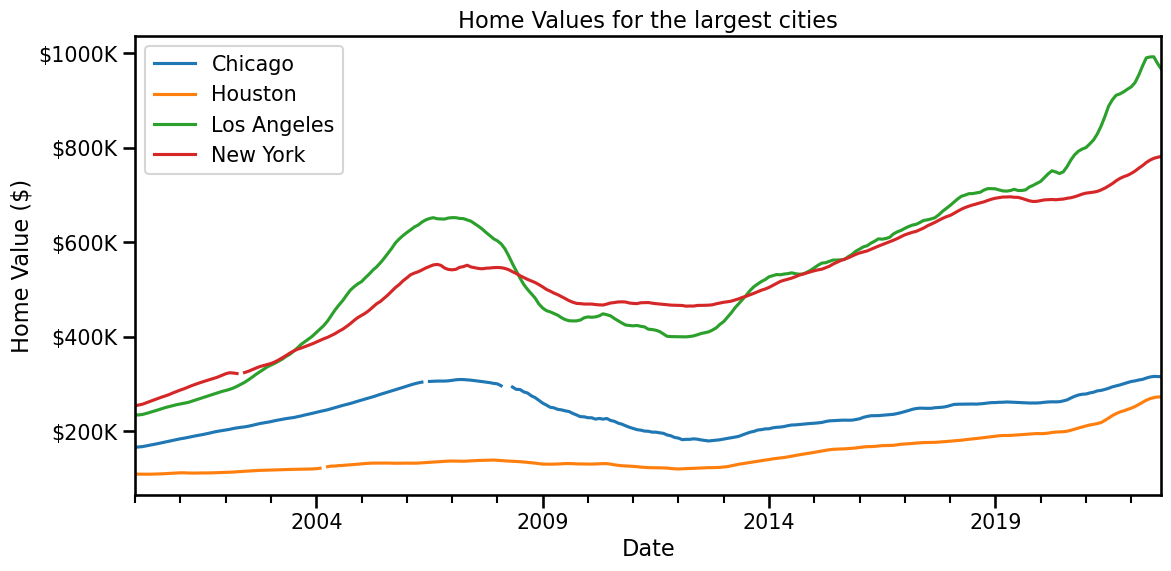

In [13]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 

fig, ax = plt.subplots(figsize=(12,6))
resampled_df.unstack(level=0)['HomeValue'].plot(ax=ax)

# adding the title and axis labels
ax.set_title('Home Values for the largest cities')
ax.set_xlabel('Date')
ax.set_ylabel('Home Value ($)')

# Reformat y-axis ticks to use thousands of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

plt.legend()
plt.tight_layout()
plt.show()

## Which City had the highest Typical Home Value at the end of 2008? Which had the least?

In [22]:
# filter the year 2008
data_2008 = resampled_df.loc[resampled_df.index.get_level_values('Date').year == 2008]

# print the filtered year
print(data_2008.head())

                       RegionID  SizeRank  HomeValue
RegionName Date                                     
Chicago    2008-01-31   17426.0       3.0   300207.0
           2008-02-29   17426.0       3.0   296063.0
           2008-03-31   17426.0       3.0        NaN
           2008-04-30   17426.0       3.0        NaN
           2008-05-31   17426.0       3.0   293467.0


In [24]:
unstacked_data = data_2008.unstack('RegionName')['HomeValue']
print(unstacked_data)

RegionName   Chicago   Houston  Los Angeles  New York
Date                                                 
2008-01-31  300207.0  138208.0     603029.0  546538.0
2008-02-29  296063.0  137512.0     596635.0  546098.0
2008-03-31       NaN  136795.0     586065.0  544562.0
2008-04-30       NaN  136628.0     571226.0  541865.0
2008-05-31  293467.0  136228.0     554589.0  537685.0
2008-06-30  288495.0  135773.0     539622.0  533810.0
2008-07-31  288174.0  135392.0     524220.0  529211.0
2008-08-31  283199.0  134770.0     510520.0  525290.0
2008-09-30  280695.0  133932.0     500124.0  521347.0
2008-10-31  274849.0  133189.0     490979.0  518048.0
2008-11-30  271059.0  132247.0     481905.0  514767.0
2008-12-31  265306.0  131283.0     469294.0  510309.0


In [26]:
# Find the city with the highest home value at the end of 2008
highest_value_city = unstacked_data.iloc[-1].idxmax()

print("City with the highest typical home value at the end of 2008:", highest_value_city)


City with the highest typical home value at the end of 2008: New York


In [27]:
# Find the city with the lowest home value at the end of 2008
lowest_value_city = unstacked_data.iloc[-1].idxmin()

print("City with the lowest typical home value at the end of 2008:", lowest_value_city)


City with the lowest typical home value at the end of 2008: Houston


1. New York has the highest home value at the end of 2008. 
2. Houston has the lowest home values at the end of 2008. 

## How much did the home values change from November 2008 to December 2008 (in dollars)?

In [33]:
# filtering the dates from 11/2008 to 12/2008
ds = df_unstacked['HomeValue'].loc['2008-11':'2008-12'].copy()
ds


RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-30,271059.0,132247.0,481905.0,514767.0
2008-12-31,265306.0,131283.0,469294.0,510309.0


In [34]:
ds_diff = ds.diff()
ds_diff

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-30,NaN,NaN,NaN,NaN
2008-12-31,-5753.0,-964.0,-12611.0,-4458.0


1. Changes in home values from Nov 2008 to Dec 2008 Chicago - $5,753.00

2. Houston - $964.00

3. Los Angeles - $12,611.00

4. New York - $4,458.00